In [1]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Lambda, Concatenate, BatchNormalization
from tensorflow.keras.layers import Input, Add, Conv2D, MaxPooling2D, AveragePooling2D, Softmax, InputLayer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from keras import backend as K

# set random seed value for reproducable results
seed_value= 4815
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

print(f"tf version: {tf.__version__}")
print("GPUs: ", tf.config.list_physical_devices('GPU'))

tf version: 2.10.0
GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
EPOCHS = 20
BATCH_SIZE_TRAIN = 64
LEARNING_RATE = 0.001
VALIDATION = True

# load data

In [3]:
data_path = "data/"
train_path = data_path + "train2014/train2014"
val_path = data_path + "val2014/val2014"

with open(os.path.join(train_path +"_processed.pickle"), "rb") as f:
    training_data = pickle.load(f)
len_training_data_raw = len(training_data)

with open(os.path.join(val_path + "_processed.pickle"), "rb") as f:
    validation_data = pickle.load(f)

training_data = training_data[:len(training_data) // BATCH_SIZE_TRAIN * BATCH_SIZE_TRAIN]
print(f"number training data: {len(training_data)}")
print("batch_size_train: " + str(BATCH_SIZE_TRAIN))
if VALIDATION:
    # batch_size_val = int(BATCH_SIZE_TRAIN * (len(validation_data) / (len_training_data_raw + len(validation_data))))
    batch_size_val = BATCH_SIZE_TRAIN
    validation_data = validation_data[:len(validation_data) // batch_size_val * batch_size_val]
    print(f"number validation data: {len(validation_data)}")
    print(f"batch_size_val: {batch_size_val}")

number training data: 78720
batch_size_train: 64
number validation data: 38528
batch_size_val: 64


# construct network

In [4]:
def homography_net():
    input_shape = (128, 128, 2)
    kernel_size = 3
    pool_size = 2
    filters = 64
    dropout = 0.5

    model = Sequential()
    model.add(InputLayer(input_shape))
    model.add(Conv2D(filters=filters,\
            kernel_size=kernel_size, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=filters,\
            kernel_size=kernel_size, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size))
    model.add(Conv2D(filters=filters,\
            kernel_size=kernel_size, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=filters,\
            kernel_size=kernel_size, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size))
    model.add(Conv2D(filters=filters*2,\
            kernel_size=kernel_size, activation='relu', padding='same',))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=filters*2,\
            kernel_size=kernel_size, activation='relu', padding='same',))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size))
    model.add(Conv2D(filters=filters*2,\
            kernel_size=kernel_size, activation='relu', padding='same',))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=filters*2,\
            kernel_size=kernel_size, activation='relu', padding='same',))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(8))
    return model

model = homography_net()
sgd = tf.optimizers.SGD(learning_rate=0.005, momentum=0.9)

def euclidean_l2(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1, keepdims=True))
model.compile(optimizer=sgd, loss=euclidean_l2, metrics=['mean_squared_error'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1216      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                        

# train network

In [8]:
model_path = "model"

# generator for model.fit()
def generate(batch_size, s='train'):
    batch_index = 0
    while True:
        if s == 'train':
            data = training_data
        elif s == 'val':
            data = validation_data
        else:
            print('check operation mode parameter')
            return None

        batch_x, batch_y = [], []
        for i in range(batch_size):
            index = batch_index + i
            if index >= len(data):
                print("WARNING: check if batch size is factor of data size")
                index = index % len(data)
            batch_x.append((data[index][0].astype(float) - 127.5) / 127.5)
            batch_y.append(data[index][1].astype(float).flatten())
        
        batch_x = np.asarray(batch_x)
        batch_y = np.asarray(batch_y)

        yield batch_x, batch_y
        batch_index += batch_size

        # reset batch_index if next epoch
        if s=='train' and batch_index >= len(training_data):
            batch_index = 0
        elif s=='val' and batch_index >= len(validation_data):
            batch_index = 0

if VALIDATION:
    history = model.fit(generate(BATCH_SIZE_TRAIN, s='train'), epochs=EPOCHS, steps_per_epoch = len(training_data)//BATCH_SIZE_TRAIN, validation_data = generate(batch_size_val, s='val'), validation_steps = len(validation_data)//batch_size_val)
else:
    history = model.fit(generate(BATCH_SIZE_TRAIN, s='train'), epochs=EPOCHS, steps_per_epoch = len(training_data)//BATCH_SIZE_TRAIN)

current_time = datetime.now().strftime("%H_%M_%S")
model.save(model_path + "/model_" + current_time, save_format='tf')

Epoch 1/20
1230/1230 [==============================] - 175s 142ms/step - loss: 0.4346 - mean_squared_error: 0.0324 - val_loss: 0.3212 - val_mean_squared_error: 0.0189
Epoch 2/20
1230/1230 [==============================] - 188s 153ms/step - loss: 0.3963 - mean_squared_error: 0.0278 - val_loss: 0.2677 - val_mean_squared_error: 0.0143
Epoch 3/20
1230/1230 [==============================] - 183s 149ms/step - loss: 0.3670 - mean_squared_error: 0.0246 - val_loss: 0.3045 - val_mean_squared_error: 0.0172
Epoch 4/20
1230/1230 [==============================] - 185s 150ms/step - loss: 0.3430 - mean_squared_error: 0.0219 - val_loss: 0.2469 - val_mean_squared_error: 0.0127
Epoch 5/20
1230/1230 [==============================] - 177s 144ms/step - loss: 0.3263 - mean_squared_error: 0.0202 - val_loss: 0.2605 - val_mean_squared_error: 0.0128
Epoch 6/20
1230/1230 [==============================] - 171s 139ms/step - loss: 0.3093 - mean_squared_error: 0.0186 - val_loss: 0.2489 - val_mean_squared_error:

INFO:tensorflow:Assets written to: model/model_19_08_31\assets


INFO:tensorflow:Assets written to: model/model_19_08_31\assets


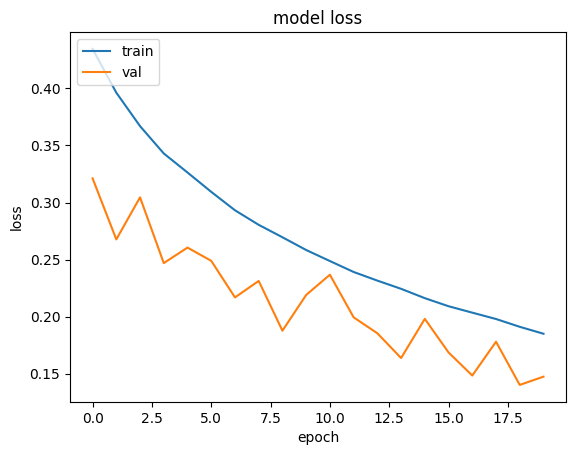

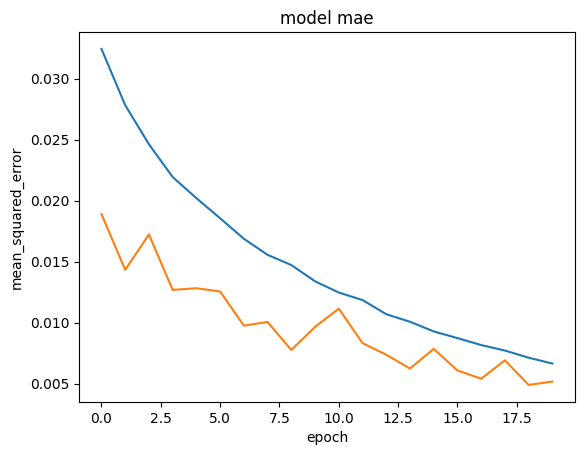

In [9]:
plt.plot(history.history['loss'])
if VALIDATION:
    plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# visualize mse
plt.plot(history.history['mean_squared_error'])
if VALIDATION:
    plt.plot(history.history['val_mean_squared_error'])
plt.title('model mae')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.show()